### Loading dataset

In [3]:
import pandas as pd


def load_yelp_orig_data(yelp_path):
    data = []
    i = 0
    # read the entire file into a python array
    with open(yelp_path, 'r') as f:
        for line in f:
            data.append(line)
            i += 1
            if i == 100000:
                break
        #data = f.readlines()

    # remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    data_json_str = "[" + ','.join(data) + "]"

    # now, load it into pandas
    data_df = pd.read_json(data_json_str)

    data_df.to_csv('../data/output_reviews_top.csv')

load_yelp_orig_data("../data/yelp_academic_dataset_review.json")

In [4]:
top_data_df = pd.read_csv('../data/output_reviews_top.csv')
print("Columns in the original dataset:\n")
print(top_data_df.columns)

Columns in the original dataset:

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date'],
      dtype='object')


### Exploring dataset

Number of rows per star rating:
5    44088
4    22805
1    13742
3    11179
2     8186
Name: stars, dtype: int64


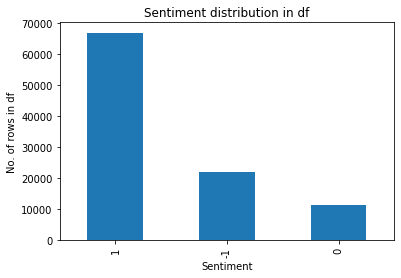

In [5]:
import matplotlib.pyplot as plt 

print("Number of rows per star rating:")
print(top_data_df['stars'].value_counts())

# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['sentiment'] = [ map_sentiment(x) for x in top_data_df['stars']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [6]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['sentiment'] == -1].head(top_n)
    top_data_df_neutral = top_data_df[top_data_df['sentiment'] == 0].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_small

# Function call to get the top 10000 from each sentiment
top_data_df_small = get_top_data(top_n=10000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['sentiment'].value_counts())
top_data_df_small.head(5)

After segregating and taking equal number of rows for each sentiment:
 0    10000
 1    10000
-1    10000
Name: sentiment, dtype: int64


Unnamed: 0               review_id                 user_id  \
2           2  LG2ZaYiOgpr2DK_90pYjNw  V34qejxNsCbcgD8C0HVk-Q   
4           4  6TdNDKywdbjoTkizeMce8A  UgMW8bLE0QMJDCkQ1Ax5Mg   
5           5  L2O_INwlrRuoX05KSjc4eg  5vD2kmE25YBrbayKhykNxQ   
6           6  ZayJ1zWyWgY9S_TRLT_y9Q  aq_ZxGHiri48TUXJlpRkCQ   
7           7  lpFIJYpsvDxyph-kPzZ6aA  dsd-KNYKMpx6ma_sRWCSkQ   

              business_id  stars  useful  funny  cool  \
2  HQl28KMwrEKHqhFrrDqVNQ      5       1      0     0   
4  IS4cv902ykd8wj1TR0N3-A      4       0      0     0   
5  nlxHRv1zXGT0c0K51q3jDg      5       2      0     0   
6  Pthe4qk5xh4n-ef-9bvMSg      5       1      0     0   
7  FNCJpSn0tL9iqoY3JC73qw      5       0      0     0   

                                                text                 date  \
2  I love Deagan's. I do. I really do. The atmosp...  2015-12-05 03:18:11   
4  Oh happy day, finally have a Canes near my cas...  2017-01-14 21:56:57   
5  This is definitely my favorite fast food sub s...  2013-05-07 07:25:25   
6  Really good place with simple decor, amazing f...  2015-11-05 23:11:05   
7  Awesome office and staff, very professional an...  2017-07-18 18:31:54   

   sentiment  
2          1  
4          1  
5          1  
6          1  
7          1

### Pre-processing

#### 1. Removal of stop words

#### NOT USED! It can accidentally convert a negative review into positive, etc.

In [1]:
from gensim.parsing.preprocessing import remove_stopwords
print(remove_stopwords("Restaurant had a really good service!!"))
print(remove_stopwords("I did not like the food!!"))
print(remove_stopwords("This product is not good!!"))

Restaurant good service!!
I like food!!
This product good!!


#### 2. Tokenization 

In [7]:
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
print(top_data_df_small['tokenized_text'].head(10))

2     [love, deagan, do, really, do, the, atmosphere...
4     [oh, happy, day, finally, have, canes, near, m...
5     [this, is, definitely, my, favorite, fast, foo...
6     [really, good, place, with, simple, decor, ama...
7     [awesome, office, and, staff, very, profession...
8     [most, delicious, authentic, italian, ve, had,...
9     [have, been, here, twice, very, nice, and, lai...
10    [maria, is, very, good, at, what, she, does, w...
11    [order, in, delivery, review, discovered, this...
12    [we, purchased, new, office, furniture, from, ...
Name: tokenized_text, dtype: object


#### 3. Stemming

In [8]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

2     [love, deagan, do, realli, do, the, atmospher,...
4     [oh, happi, dai, final, have, cane, near, my, ...
5     [thi, is, definit, my, favorit, fast, food, su...
6     [realli, good, place, with, simpl, decor, amaz...
7     [awesom, offic, and, staff, veri, profession, ...
8     [most, delici, authent, italian, ve, had, in, ...
9     [have, been, here, twice, veri, nice, and, lai...
10    [maria, is, veri, good, at, what, she, doe, wi...
11    [order, in, deliveri, review, discov, thi, pla...
12    [we, purchas, new, offic, furnitur, from, thi,...
Name: stemmed_tokens, dtype: object